In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Load the dataset
data = pd.read_csv("wtbdata_245days.csv")
tlocdata = pd.read_csv("turbine_location.csv")

In [3]:
# For the given time t, due to the faulty performance of some thermometers we are assuming some error will happen
# while calculating External Temperatures and hence those values which fall outside the defined range will be 
# assigned a median value
f = 'Etmp'

#Create a timestamp field
data['date'] = [t for t in zip(data['Day'].values, data['Tmstamp'].values)]

# calulate the mean/std/median of the external temp for each date
tmp_data = data[['date','TurbID','Tmstamp','Day',f]]
mu = tmp_data.groupby('date')[f].mean().reset_index().rename({f:'mean'}, axis=1)
std = tmp_data.groupby('date')[f].std().reset_index().rename({f:'std'}, axis=1)
median = tmp_data.groupby('date')[f].median().reset_index().rename({f:'median'}, axis=1)

# Adding the mean,median and standard deviation for the external temperature of all the dates to the dataset
f_limit_df = pd.merge(mu, std, how='left', left_on='date', right_on='date')
f_limit_df = pd.merge(f_limit_df, median, how='left', left_on='date', right_on='date')

# calulate the range 
f_limit_df['bottom_limit'] = f_limit_df['mean'] - 3*f_limit_df['std']
f_limit_df['upper_limit'] = f_limit_df['mean'] + 3*f_limit_df['std']

# Add those within the range to the dataset
data = pd.merge(data, f_limit_df[['date','bottom_limit','upper_limit', 'median']], how='left', left_on='date', right_on='date')
data[f'abnormal_{f}'] = (data[f] < data['bottom_limit']) | (data[f] > data['upper_limit'])

# Delete the columns which were created to perform the above function after assigning median values to the 
# temperature values outside the range
data.loc[data[f'abnormal_{f}'], f] = 0
data[f] = data[f'abnormal_{f}']*data['median'] + data[f]
data = data.drop(['bottom_limit','upper_limit','median','date',f'abnormal_{f}'], axis=1)

In [4]:
nan_rows = data.isnull().any(axis=1)

# We first define the abnormal values by defining the abnormal conditions
invalid_cond = (data['Patv'] < 0) | \
                   ((data['Patv'] == 0) & (data['Wspd'] > 2.5)) | \
                   ((data['Pab1'] > 89) | (data['Pab2'] > 89) | (data['Pab3'] > 89)) | \
                   ((data['Wdir'] < -180) | (data['Wdir'] > 180) | (data['Ndir'] < -720) |\
                    (data['Ndir'] > 720))

# Except the turbid, day and tmstmp values of the invalid rows make everything else null
req_cols = set(data.columns) - {'TurbID', 'Day', 'Tmstamp'}
data.loc[invalid_cond, list(req_cols)] = np.nan

# Defining the abnormal values for power
data.loc[(data['Prtv'] < 0) & (data['Patv'] > 0), 'Prtv'] = np.nan
data.loc[(data['Prtv'] < 0) & (data['Patv'] <= 0), 'Prtv'] = 0
data.loc[data['Patv'] < 0, 'Patv'] = 0

# Filling in the null values
data = data.groupby(data.TurbID.values).ffill().bfill()

In [5]:
# Using the max of the 3 pitch blade angles instead of the individual blades
data['Pab_max'] = data[['Pab1', 'Pab2', 'Pab3']].max(axis=1)
data = data.drop(columns=['Pab1', 'Pab2', 'Pab3'])

[21:37:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



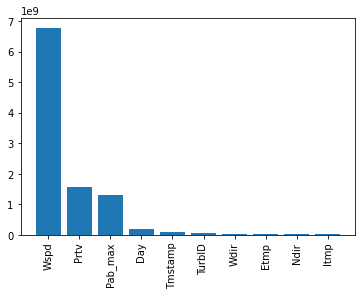

In [6]:
# Convert datetime columns to numerical type
data['Tmstamp'] = pd.to_datetime(data['Tmstamp'])
data['Tmstamp'] = pd.to_numeric(data['Tmstamp'])

# Defining the XGBoost model parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "auc",
    "max_depth": 4,
    "learning_rate": 0.1,
    "silent": 1
}

# Training the XGBoost model
dtrain = xgb.DMatrix(data.drop(["Patv"], axis=1), label=data["Patv"])
model = xgb.train(params, dtrain, num_boost_round=100)

# Calculate feature importance
importance = model.get_score(importance_type="gain")
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Plotting the graph to show the importance of the various features in the dataset
plt.bar(range(len(importance)), [val[1] for val in importance], align="center")
plt.xticks(range(len(importance)), [val[0] for val in importance])
plt.xticks(rotation=90)
plt.show()

In [7]:
# Normalizing hours and minutes of a time series dataset
temp = pd.to_datetime(data['Tmstamp'])
hours = temp.dt.hour
minutes = temp.dt.minute

normalized_hours = np.sin(2*np.pi*hours/24)
normalized_minutes = np.cos(2*np.pi*minutes/60)

# Adding the normalized values to the dataset
data['hour'] = normalized_hours
data['minute'] = normalized_minutes

# Calculating the wind direction angle and normalizing it 
data['w_angle'] = data['Ndir'] + data['Wdir']
data['w_angle_sin'] = np.sin(data['w_angle'] * np.pi/180)
data['w_angle_cos'] = np.cos(data['w_angle'] * np.pi/180)

print(data)

         TurbID  Day              Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  \
0             1    1  1679875200000000000  6.17 -3.99  30.73  41.80   25.92   
1             1    1  1679875800000000000  6.17 -3.99  30.73  41.80   25.92   
2             1    1  1679876400000000000  6.27 -2.18  30.60  41.63   20.91   
3             1    1  1679877000000000000  6.42 -0.73  30.52  41.52   20.91   
4             1    1  1679877600000000000  6.25  0.89  30.49  41.38   20.91   
...         ...  ...                  ...   ...   ...    ...    ...     ...   
4727515     134  245  1679958600000000000  7.79  2.80  -0.07   3.95  216.51   
4727516     134  245  1679959200000000000  8.06  4.39   0.23   3.94  216.51   
4727517     134  245  1679959800000000000  8.08  2.28  -0.16   4.15  216.51   
4727518     134  245  1679960400000000000  8.46  0.80  -0.14   4.32  216.51   
4727519     134  245  1679961000000000000  8.68  0.52  -0.06   4.39  216.51   

          Prtv     Patv  Pab_max      hour  minute 

In [8]:
# Convert the date column to datetime format
data['Tmstamp'] = pd.to_datetime(data['Tmstamp'])

# Set the date column as the index
data.set_index('Tmstamp', inplace=True)

#Finding the rolling mean, median, std and variance for the below features
for fea in ['Wspd', 'Wdir', 'Etmp']:
    data['Rolling_Mean_'+fea] = data[fea].rolling(window=5,min_periods=1).mean()
    data['Rolling_Median_'+fea] = data[fea].rolling(window=5,min_periods=1).median()
    data['Rolling_Std_'+fea] = data[fea].rolling(window=5,min_periods=1).std()
    data['Rolling_Var_'+fea] = data[fea].rolling(window=5,min_periods=1).var()

data = data.groupby(data.TurbID.values).ffill().bfill()
print(data)

                     TurbID  Day  Wspd  Wdir   Etmp   Itmp    Ndir   Prtv  \
Tmstamp                                                                     
2023-03-27 00:00:00       1    1  6.17 -3.99  30.73  41.80   25.92   0.01   
2023-03-27 00:10:00       1    1  6.17 -3.99  30.73  41.80   25.92   0.01   
2023-03-27 00:20:00       1    1  6.27 -2.18  30.60  41.63   20.91   0.01   
2023-03-27 00:30:00       1    1  6.42 -0.73  30.52  41.52   20.91   0.01   
2023-03-27 00:40:00       1    1  6.25  0.89  30.49  41.38   20.91   0.01   
...                     ...  ...   ...   ...    ...    ...     ...    ...   
2023-03-27 23:10:00     134  245  7.79  2.80  -0.07   3.95  216.51  33.11   
2023-03-27 23:20:00     134  245  8.06  4.39   0.23   3.94  216.51  33.11   
2023-03-27 23:30:00     134  245  8.08  2.28  -0.16   4.15  216.51  33.11   
2023-03-27 23:40:00     134  245  8.46  0.80  -0.14   4.32  216.51  33.11   
2023-03-27 23:50:00     134  245  8.68  0.52  -0.06   4.39  216.51  33.11   

In [9]:
#Dropping the low importance features
data = data.drop(['Itmp','Ndir'],axis=1)

print("Feature Set = ",data.columns)

Feature Set =  Index(['TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Prtv', 'Patv', 'Pab_max',
       'hour', 'minute', 'w_angle', 'w_angle_sin', 'w_angle_cos',
       'Rolling_Mean_Wspd', 'Rolling_Median_Wspd', 'Rolling_Std_Wspd',
       'Rolling_Var_Wspd', 'Rolling_Mean_Wdir', 'Rolling_Median_Wdir',
       'Rolling_Std_Wdir', 'Rolling_Var_Wdir', 'Rolling_Mean_Etmp',
       'Rolling_Median_Etmp', 'Rolling_Std_Etmp', 'Rolling_Var_Etmp'],
      dtype='object')


In [10]:
#Defining the sizes of train, test and validation set
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Calculating the number of data points for each split
n = len(data)
train_end = int(train_size * n)
val_end = train_end + int(val_size * n)

# Split the data based on time into training, validation, and testing sets
train_data = data.iloc[:train_end]
val_data = data.iloc[train_end:val_end]
test_data = data.iloc[val_end:]

print("Training data ",train_data.head(1),train_data.tail(1))
print("Validation data ",val_data.head(1),val_data.tail(1))
print("Testing data ",test_data.head(1),test_data.tail(1))

Training data              TurbID  Day  Wspd  Wdir   Etmp  Prtv    Patv  Pab_max  hour  \
Tmstamp                                                                   
2023-03-27       1    1  6.17 -3.99  30.73  0.01  494.66      1.0   0.0   

            minute  ...  Rolling_Std_Wspd  Rolling_Var_Wspd  \
Tmstamp             ...                                       
2023-03-27     1.0  ...               0.0               0.0   

            Rolling_Mean_Wdir  Rolling_Median_Wdir  Rolling_Std_Wdir  \
Tmstamp                                                                
2023-03-27              -3.99                -3.99               0.0   

            Rolling_Var_Wdir  Rolling_Mean_Etmp  Rolling_Median_Etmp  \
Tmstamp                                                                
2023-03-27               0.0              30.73                30.73   

            Rolling_Std_Etmp  Rolling_Var_Etmp  
Tmstamp                                         
2023-03-27               0.0         

In [13]:
train_data.to_csv('train_data.csv', index=False)

In [14]:
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [11]:
# import pandas as pd

# # Load the dataset
# df = pd.read_csv('wind_power_data.csv')

# # Convert the time column to a numeric value
# def time_to_minutes(time_str):
#     parts = time_str.split(':')
#     return int(parts[0]) * 60 + int(parts[1])

# df['time'] = df['time'].apply(time_to_minutes)

# # Convert the power column to float values
# df['power'] = df['power'].astype(float)

# # Split the dataset into training and testing sets
# train_df = df[df['time'] < 1000]
# test_df = df[df['time'] >= 1000]

# # Train the model
# from sklearn.ensemble import GradientBoostingRegressor

# gbdt = GradientBoostingRegressor()
# gbdt.fit(train_df[['time']], train_df['power'])

# # Evaluate the model
# from sklearn.metrics import mean_squared_error, r2_score

# y_pred = gbdt.predict(test_df[['time']])
# mse = mean_squared_error(test_df['power'], y_pred)
# r2 = r2_score(test_df['power'], y_pred)

# print('Mean squared error:', mse)
# print('R2 score:', r2)



In [12]:
# import pandas as pd
# import numpy as np
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import TimeSeriesSplit

# # Load the dataset
# df = pd.read_csv('wind_power_data.csv')

# # Convert the time column to datetime format and set it as index
# df['time'] = pd.to_datetime(df['time'])
# df.set_index('time', inplace=True)

# # Split the dataset into training and testing sets
# train_size = int(len(df) * 0.8)
# train_df = df[:train_size]
# test_df = df[train_size:]

# # Define the features and target variables
# X_train = train_df.drop('power', axis=1)
# y_train = train_df['power']
# X_test = test_df.drop('power', axis=1)
# y_test = test_df['power']

# # Define the LightGBM model and hyperparameters
# lgbm = LGBMRegressor(
#     n_estimators=1000,
#     learning_rate=0.01,
#     max_depth=5,
#     min_child_samples=10,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# # Train the model using time series cross-validation
# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, val_index in tscv.split(X_train):
#     X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

#     lgbm.fit(X_train_fold, y_train_fold,
#              eval_set=[(X_val_fold, y_val_fold)],
#              early_stopping_rounds=50,
#              verbose=False)

# # Make predictions on the test set
# y_pred = lgbm.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print('Mean squared error:', mse)
# print('R2 score:', r2)
